In [1]:
from __future__ import print_function

import lime
import lime.lime_tabular
import sklearn
import numpy as np
import pandas as pd
import sklearn
import sklearn.ensemble
import sklearn.metrics
import scipy.io

np.random.seed(1)
%matplotlib inline
import matplotlib.pyplot as plt

## Loading data
Breast Cancer Wisconsin (Diagnostic) Data Set Predict whether the cancer is benign or malignant

In [2]:
mat = scipy.io.loadmat('./data/wbc.mat')
wbc_df = pd.DataFrame(np.hstack((mat['X'], mat['y'])))
wbc_df.columns = ["radius_mean", "texture_mean","perimeter_mean", "area_mean", "smoothness_mean", "compactness_mean", 
                  "concavity_mean", "concave.points_mean", "symmetry_mean", "fractal_dimension_mean", 
                  "radius_se", "texture_se","perimeter_se", "area_se", "smoothness_se", "compactness_se", 
                  "concavity_se", "concave.points_se", "symmetry_se", "fractal_dimension_se", 
                  "radius_worst", "texture_worst","perimeter_worst", "area_worst", "smoothness_worst", 
                  "compactness_worst", "concavity_worst", "concave.points_worst", "symmetry_worst", 
                  "fractal_dimension_worst",
                  "outlier"]
wbc_df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave.points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave.points_worst,symmetry_worst,fractal_dimension_worst,outlier
0,0.310426,0.157254,0.301776,0.179343,0.407692,0.189896,0.156139,0.237624,0.416667,0.162174,...,0.192964,0.245480,0.129276,0.480948,0.145540,0.190895,0.442612,0.278336,0.115112,0.0
1,0.288655,0.202908,0.289130,0.159703,0.495351,0.330102,0.107029,0.154573,0.458081,0.382266,...,0.225746,0.227501,0.109443,0.396421,0.242852,0.150958,0.250275,0.319141,0.175718,0.0
2,0.119409,0.092323,0.114367,0.055313,0.449309,0.139685,0.069260,0.103181,0.381313,0.402064,...,0.097015,0.073310,0.031877,0.404345,0.084903,0.070823,0.213986,0.174453,0.148826,0.0
3,0.286289,0.294555,0.268261,0.161315,0.335831,0.056070,0.060028,0.145278,0.205556,0.182603,...,0.287580,0.169580,0.088650,0.170640,0.018337,0.038602,0.172268,0.083185,0.043618,0.0
4,0.057504,0.241123,0.054730,0.024772,0.301255,0.122845,0.037207,0.029409,0.358081,0.317397,...,0.264925,0.034115,0.014009,0.386515,0.105180,0.054952,0.088110,0.303568,0.124951,0.0


In [3]:
wbc_df.shape

(378, 31)

Train-Test split, 80%-20%

In [4]:
from sklearn.model_selection import train_test_split
train, test, labels_train, labels_test = train_test_split(wbc_df.loc[:, wbc_df.columns != 'outlier'], wbc_df['outlier'], train_size=0.80, random_state=123)

/home/nisha/anaconda2/envs/lime/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Training model

In [5]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(train, labels_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [6]:
sklearn.metrics.accuracy_score(labels_test, rf.predict(test))

0.9473684210526315

The overall feature importance plot

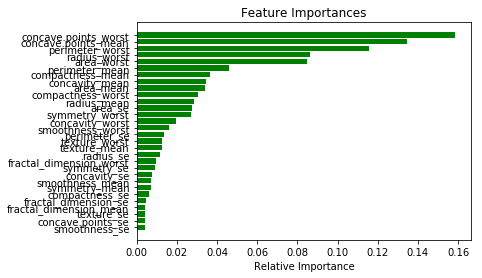

In [7]:
features = train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Create the explainer
Creating a tabular explainer for the training set.

In [8]:
explainer = lime.lime_tabular.LimeTabularExplainer(train, feature_names=train.columns, 
                                                   class_names=['benign', 'malignant'], 
                                                   discretize_continuous=False)

## Explaining an instance
Since this is a binary-class classification problem, it explains the class with the top probability by default.

In [9]:
# i = np.random.randint(0, test.shape[0])
i = 1
exp = explainer.explain_instance(test.values[i], rf.predict_proba)
exp.as_list()

[('perimeter_worst', 0.022720254025040878),
 ('concave.points_worst', 0.018522188321386655),
 ('area_worst', 0.016098210118724626),
 ('radius_worst', 0.015352130047039846),
 ('perimeter_mean', 0.011558973112324511),
 ('area_mean', 0.009067645714423162),
 ('radius_mean', 0.006912355430688037),
 ('texture_worst', 0.006149303624562476),
 ('texture_mean', 0.004018357172950036),
 ('compactness_worst', 0.0037636744981734594)]

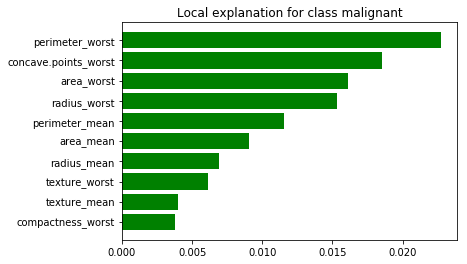

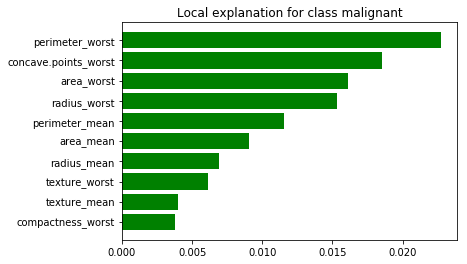

In [10]:
exp.as_pyplot_figure()

### Explaining another instance
Another example, notice how the explanations vary depending on the example you select. In the case below, 'concave.points_worst' has a higher contribution for being an outlier.

In [11]:
i=61 # another malignant tumour example
exp = explainer.explain_instance(test.values[i], rf.predict_proba)
exp.as_list()

[('perimeter_worst', 0.022720216173161386),
 ('concave.points_worst', 0.02069493305848242),
 ('area_worst', 0.015157578451854697),
 ('radius_worst', 0.014347605399125704),
 ('concave.points_mean', 0.013738308920260504),
 ('concavity_mean', 0.00983069670383219),
 ('area_mean', 0.00877775348355768),
 ('perimeter_mean', 0.007723505731351466),
 ('radius_mean', 0.0072604299945275745),
 ('concavity_worst', 0.002616168754160644)]